##Setup


In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.


In [84]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

## **Importing our Morse Code Alphabet dataset**

We collected **our own dataset** of morse code audios which consists of 780 different audios of morse code aplhabet

We import it from Google Drive in WAV , there are 30 audios in each Alphabet letter 


In [85]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
DATASET_PATH = '/content/drive/MyDrive/morse_audio/'
data_dir = pathlib.Path(DATASET_PATH)

**Our** dataset's audio clips are stored in folders corresponding to each alphabet letter

In [155]:
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
labels = labels[(labels != 'README.md') & (labels != '.DS_Store')]
print('Labels:', labels)

Labels: ['H' 'I' 'A' 'B' 'D' 'C' 'F' 'G' 'E' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'T' 'V' 'W' 'X' 'Y' 'Z' 'S' 'U']


The TensorFlow method *tf.keras.utils.audio_dataset_from_directory()* makes it simple to generate an audio dataset from a directory. It extracts a dataset from all of the audio files in a directory after reading them all.

In [88]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 780 files belonging to 26 classes.
Using 624 files for training.
Using 156 files for validation.

label names: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


The function squeeze() removes the last dimension of the audio tensor by squeezing it. It accepts two arguments, audio and labels.

In [89]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [90]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [91]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


#### Displaying waveforms

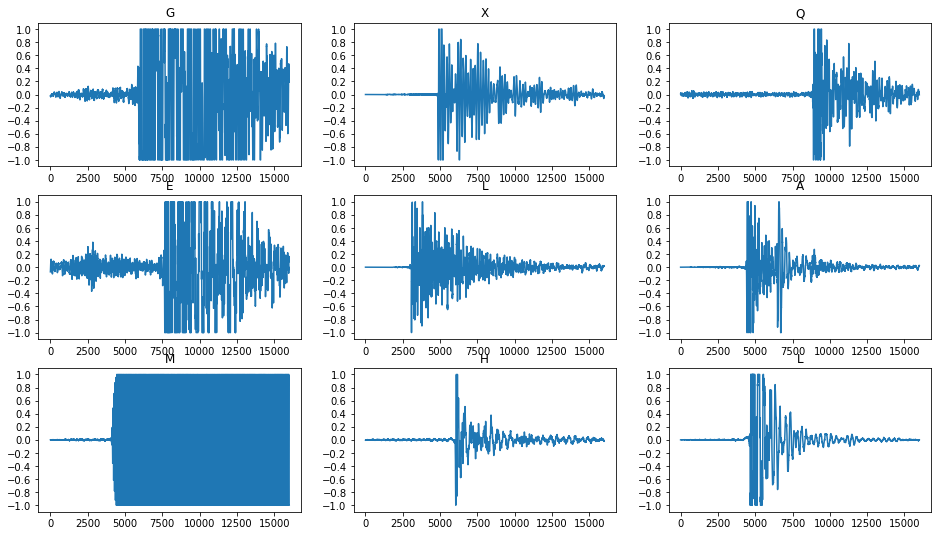

In [92]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## Convert waveforms to spectrograms



In [93]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [94]:
label = label_names[example_labels[1]]
waveform = example_audio[1]
spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=20000))

Label: X
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [95]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

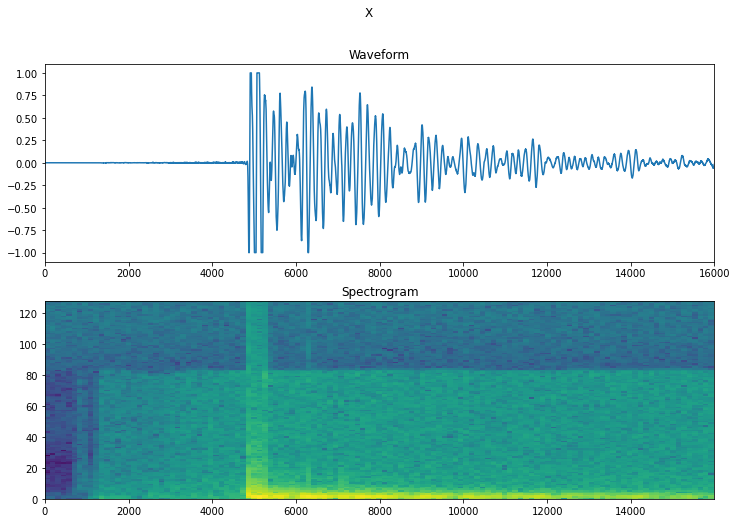

In [96]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [97]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [98]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [99]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

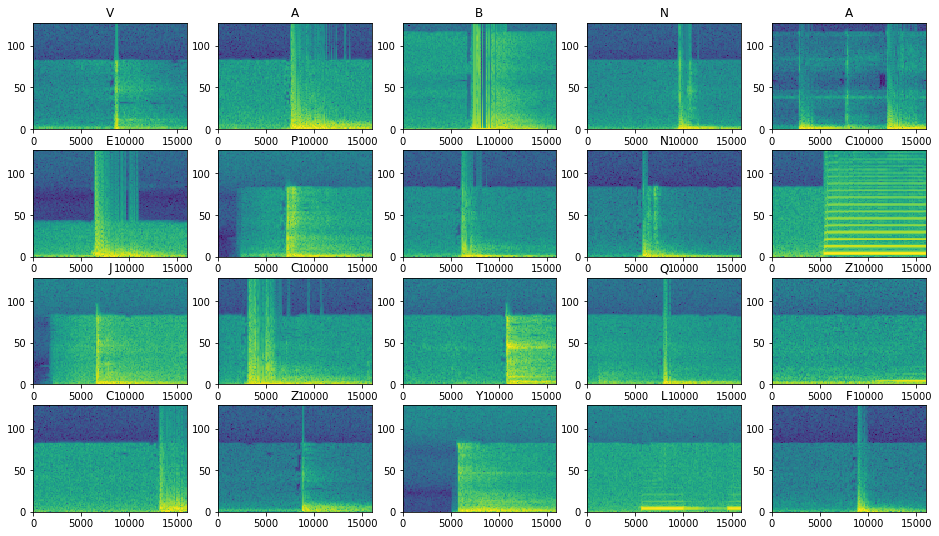

In [100]:
rows = 4
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [125]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [144]:
from keras.layers import Dropout 
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

from keras.layers import Dropout 
#creating our model
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_10 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)       

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [145]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Training the model

In [149]:
EPOCHS = 18
history = model.fit(
    train_spectrogram_ds,
    validation_data= val_spectrogram_ds,
    batch_size=32,
    epochs=EPOCHS
)

Epoch 1/18
10/10 [==============================] - 4s 447ms/step - loss: 1.2768 - accuracy: 0.6042 - val_loss: 1.4713 - val_accuracy: 0.6250
Epoch 2/18
10/10 [==============================] - 4s 442ms/step - loss: 1.2319 - accuracy: 0.6042 - val_loss: 1.3755 - val_accuracy: 0.6250
Epoch 3/18
10/10 [==============================] - 3s 291ms/step - loss: 1.1767 - accuracy: 0.6250 - val_loss: 1.3295 - val_accuracy: 0.6250
Epoch 4/18
10/10 [==============================] - 3s 294ms/step - loss: 1.1517 - accuracy: 0.6298 - val_loss: 1.4769 - val_accuracy: 0.6250
Epoch 5/18
10/10 [==============================] - 3s 319ms/step - loss: 1.1235 - accuracy: 0.6458 - val_loss: 1.3939 - val_accuracy: 0.6562
Epoch 6/18
10/10 [==============================] - 4s 415ms/step - loss: 1.0725 - accuracy: 0.6667 - val_loss: 1.3757 - val_accuracy: 0.6406
Epoch 7/18
10/10 [==============================] - 3s 292ms/step - loss: 1.0679 - accuracy: 0.6667 - val_loss: 1.3412 - val_accuracy: 0.6250
Epoch 

####To check our model's performance we plot a training and validation curves

Text(0, 0.5, 'Accuracy [%]')

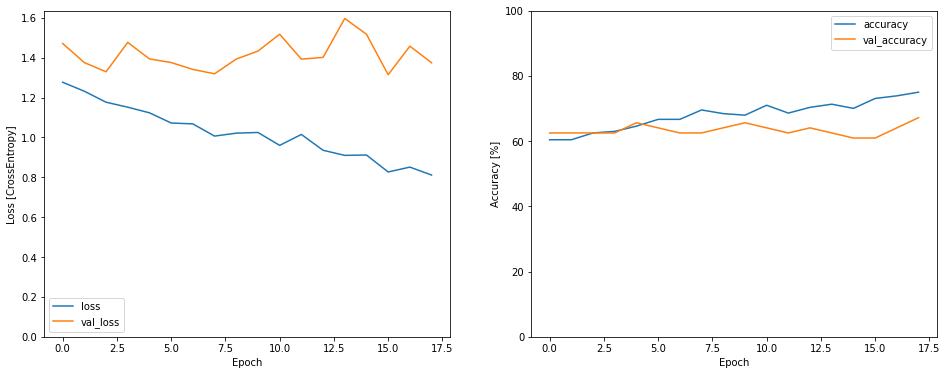

In [150]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Display a confusion matrix

In [151]:
y_pred = model.predict(test_spectrogram_ds)

2/2 [==============================] - 0s 35ms/step


In [134]:
y_pred = tf.argmax(y_pred, axis=1)

In [135]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

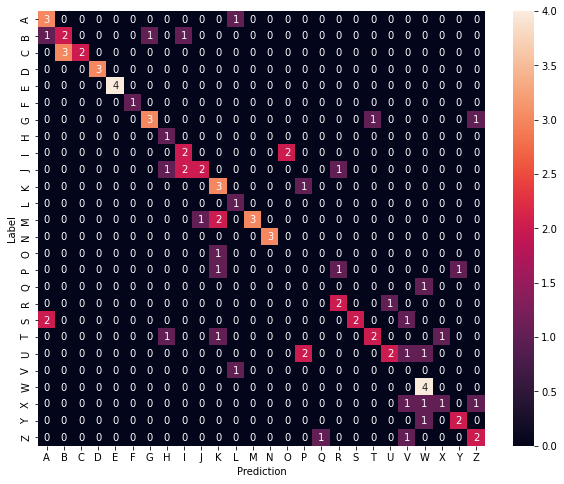

In [136]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

###Take input audio and predict it
Here it will take input as morse code and predict corresponding letter

In [137]:
!pip install torchaudio ipywebrtc
!sudo apt update
!pip install ffmpeg-python
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers

In [114]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

In [115]:
from google.colab import output
output.enable_custom_widget_manager()

In [152]:
camera = CameraStream(constraints={'audio': True,'video':False})
soile = AudioRecorder(stream=camera)
soile

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [153]:
with open('recording.webm', 'wb') as f:
    f.write(soile.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
print(sig.shape)
Audio(data=sig, rate=sr)

torch.Size([1, 69120])


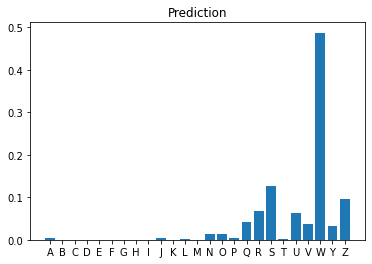

In [154]:
x = '/content/file.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['A','B','C','D','E','F','G','H','I', 'J','K','L','M','N','O','P','Q','R','S','T','U','V','W','Q','Y','Z']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prediction')
plt.show()

display.display(display.Audio(waveform, rate=10000))